In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, kruskal, f_oneway
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
'''
Data location: 'https://www.fhfa.gov/DataTools/Downloads/Pages/Public-Use-Databases.aspx'
'''
data_path = '../data/2020_SFCensusTractFNM2020/fnma_sf2020c_loans.txt'

In [3]:
###
# Read dataset
# Unfortunately there is arbitrary white space so pandas read_csv didnt work well, 
# maybe could use np.loadtxt
# Starting out with 10% sample for quickness
###
out = []
f = open(data_path,'r')
for i,line in enumerate(f.readlines()):
    if (i % 10) == 0:
        out.append(line.split())
f.close()
out = np.array(out)

In [4]:
'There are {:,} people in the dataset'.format(len(out)*10)

'There are 4,857,630 people in the dataset'

In [5]:
cols = list(range(1,65))
lend = pd.DataFrame(data=out,columns=cols)

In [6]:
# manually gathered float cols
float_cols = [7,10,13,36,42,46]
int_cols = list(set(cols) - set(float_cols))

In [7]:
lend_fmt = lend.loc[:,int_cols].astype(np.int32)

In [8]:
lend_fmt[float_cols] = lend.loc[:,float_cols].astype(np.float32)

### Question 1
Is race an indicator of interest rate?   
Idea: If there is bias in loan assemenet, certain races would have higher/lower interest rates. 

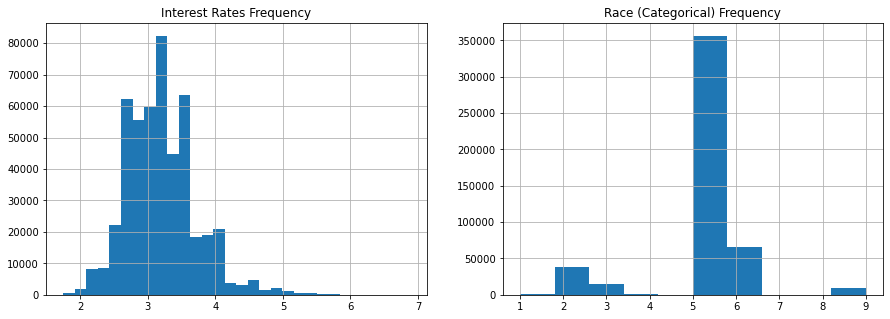

In [12]:
fix,axes = plt.subplots(1,2,figsize=(15,5))
lend_fmt.loc[:,46].hist(bins=30,ax=axes[0])
lend_fmt.loc[:,19].hist(ax=axes[1])
axes[0].set_title('Interest Rates Frequency')
_ = axes[1].set_title('Race (Categorical) Frequency')

In [13]:
# Mean interest rate by race
lend_fmt.loc[lend_fmt[19] < 6,:].groupby(19)[46].mean()

19
1    3.239842
2    3.072494
3    3.362200
4    3.268831
5    3.211729
Name: 46, dtype: float32

In [14]:
rates = []
for group in range(1,6):
    group_rate = lend_fmt.loc[lend_fmt[19] == group,46]
    # print(len(group_rate))
    rates.append(group_rate)

In [15]:
f_oneway(*rates,axis=0)

F_onewayResult(statistic=1000.3854297163618, pvalue=0.0)

In [16]:
rr = lend_fmt.loc[lend_fmt[19] < 6,[19,46]]
rr.columns = ['race','rate']

Run ANOVA on all races to see if there is a significant difference

In [17]:
model = ols("rate ~ C(race)", data=rr).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(race),1064.678379,4.0,1000.38543,0.0
Residual,109529.425602,411661.0,NaN,NaN


Means are significantly different, but what about effect size? 

In [18]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq (effect size)'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq (effect size)',]
    aov = aov[cols]
    return aov

anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq (effect size)
C(race),1064.678379,4.0,266.169595,1000.38543,0.0,0.009627
Residual,109529.425602,411661.0,0.266067,NaN,NaN,NaN


In [19]:
'''{}% of the total variance is explained by the treatment effect.
 This is a very small effect size'''.format(0.0096*100)

'0.96% of the total variance is explained by the treatment effect.\n This is a very small effect size'